In [1]:
# %tensorflow_version 2.x

In [2]:
from tensorflow import random
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score
import tensorflow as tf
import math
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# set random seed
np.random.seed(10086)
random.set_seed(10010)

## Load data

In [3]:
raw_df = pd.read_csv("./data/PRSA_Data_Huairou_20130301-20170228.csv")

raw_dfs = []
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Aotizhongxin_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Changping_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Dingling_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Dongsi_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Guanyuan_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Huairou_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Nongzhanguan_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Shunyi_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Tiantan_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Wanliu_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Wanshouxigong_20130301-20170228.csv"))
station_info=[]
for item in raw_dfs:
    station_info.append(item["station"].values[0])
station_info

['Aotizhongxin',
 'Changping',
 'Dingling',
 'Dongsi',
 'Guanyuan',
 'Huairou',
 'Nongzhanguan',
 'Shunyi',
 'Tiantan',
 'Wanliu',
 'Wanshouxigong']

In [4]:
def RHcovert(templist,dewlist):
    rh=[]
    for temp,dew in zip(templist,dewlist):
        rh.append(math.exp(17.27*dew/(237.7+dew)-17.27*temp/(237.7+temp)))
    return rh

In [5]:
# label to id,not used
def label_fit_transform(data_frame, col_name):

    data_frame[col_name] = preprocessing.LabelEncoder().fit_transform(data_frame[col_name])
    return data_frame
# standardization, make data form min-max to 0-1
def standardization(data_frame):
    buffer = data_frame.copy()
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    standard_values = min_max_scaler.fit_transform(buffer)
    for i, col_name in enumerate(buffer.columns):
        buffer[col_name] = standard_values[:, i]

    return buffer
# This step is used for lookback
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    from pandas import DataFrame, concat

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.coumns[j], i)) for j in range(n_vars)]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
def transform(values):
    return values.reshape(values.shape[0], 1, values.shape[1])

## This part is predict $PM_{2.5}$ by current condition

In [6]:
# predict ${predict_forward} hour after by look_back hours data
look_back = 0
predict_forward = 1

In [7]:
# drop usless Columns
current_data=[]
for item in raw_dfs:
    current_data.append(item.copy())
train_x=[]
train_y=[]
valid_x=[]
valid_y=[]
test_x=[]
test_y=[]
split_pointlist=[]
info_data=0
origindatalist=[]
maxlist=[]
minlist=[]
for item in current_data:
    item.drop(["No","year","month","hour", "day","wd","station"], axis=1, inplace=True)
    item["RH"]=RHcovert(item["TEMP"],item["DEWP"])
    item.drop(["TEMP","DEWP"], axis=1, inplace=True)
    item.dropna()
    item=item.reset_index()
    max_value = np.max(item["PM2.5"])
    min_value = np.min(item["PM2.5"])
    maxlist.append(max_value)
    minlist.append(min_value)
    
    item=series_to_supervised(
        standardization(item), look_back, predict_forward).drop(
        [
            "PRES(t)","index(t)"
         ], axis=1, inplace=False).astype('float32')
    item["PM2.5"]=item["PM2.5(t)"]
    item.drop(["PM2.5(t)"],axis=1,inplace=True)
    total=item.shape[0]    
    split_point = [total * 60 // 100, total * 80 // 100]
    split_pointlist.append(split_point)
    train_data = item[:split_point[0]].values
    valid_data = item[split_point[0]: split_point[1]].values
    test_data = item[split_point[1]: ].values
    train_x_temp, train_y_temp = transform(train_data[:, : -1]), train_data[:, -1]
    valid_x_temp, valid_y_temp = transform(valid_data[:, : -1]), valid_data[:, -1]
    test_x_temp, test_y_temp = transform(test_data[:, : -1]), test_data[:, -1]
    train_x.append(train_x_temp)
    train_y.append(train_y_temp)
    valid_x.append(valid_x_temp)
    valid_y.append(valid_y_temp)
    test_x.append(test_x_temp)
#     print(len(test_x_temp),split_point[1],len(item))
    test_y.append(test_y_temp)
    origindatalist.append(item)
    infodata=item

In [8]:
with open("./model/min_max_x.csv","w") as f:
    for item in current_data[0].columns.values:
        f.write(item+"min"+","+item+"max"+",")
    f.write("\n")
    for item in current_data:
        for col in item:
            f.write(str(np.min(item[col]))+","+str(np.max(item[col]))+",")
        f.write("\n")

In [9]:
infodata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32829 entries, 0 to 35063
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PM10(t)  32829 non-null  float32
 1   SO2(t)   32829 non-null  float32
 2   NO2(t)   32829 non-null  float32
 3   CO(t)    32829 non-null  float32
 4   O3(t)    32829 non-null  float32
 5   RAIN(t)  32829 non-null  float32
 6   WSPM(t)  32829 non-null  float32
 7   RH(t)    32829 non-null  float32
 8   PM2.5    32829 non-null  float32
dtypes: float32(9)
memory usage: 1.4 MB


In [10]:
current_data[0].head()

,PM2.5,PM10,SO2,NO2,CO,O3,PRES,RAIN,WSPM,RH
0,4.0,4.0,4.0,7.0,300.0,77.0,1023.0,0.0,4.4,0.238781
1,8.0,8.0,4.0,7.0,300.0,77.0,1023.2,0.0,4.7,0.258810
2,7.0,7.0,5.0,10.0,300.0,73.0,1023.5,0.0,5.6,0.258810
3,6.0,6.0,11.0,11.0,300.0,72.0,1024.5,0.0,3.1,0.238726
4,3.0,3.0,12.0,12.0,300.0,72.0,1025.2,0.0,2.0,0.247379


In [11]:
modellist=[]
for item in train_x:
    model = keras.Sequential()
    model.add(keras.layers.LSTM(32, input_shape=(item.shape[1], item.shape[2]),activation="tanh"))
    model.add(tf.keras.layers.Dense(input_shape=(None,64),units=32,activation="tanh"))
    model.add(tf.keras.layers.Dense(input_shape=(None,32),units=16,activation="relu"))
    model.add(tf.keras.layers.Dense(input_shape=(None,16),units=1024,activation="relu"))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss="mae", optimizer="Adamax")
    modellist.append(model)

In [12]:
modellist[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5248      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              17408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 25,265
Trainable params: 25,265
Non-trainable params: 0
_________________________________________________________________


In [29]:
# history = model.fit(train_x,
#                     train_y,
#                     validation_data=(valid_x, valid_y),
#                     epochs=10,
#                     batch_size=32,
#                     verbose=1,
#                     shuffle=True)
historylist=[]
for model,t_x,t_y,v_x,v_y in zip(modellist,train_x,train_y,valid_x,valid_y):
    historylist.append(model.fit(t_x,
                    t_y,
                    validation_data=(v_x, v_y),
                    epochs=32,
                    batch_size=1024,
                    verbose=1,
                    shuffle=True))

Train on 19125 samples, validate on 6375 samples
Epoch 1/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0156 - val_loss: 0.0150
Epoch 2/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0155 - val_loss: 0.0152
Epoch 3/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0154 - val_loss: 0.0151
Epoch 4/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0154 - val_loss: 0.0153
Epoch 5/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0154 - val_loss: 0.0153
Epoch 6/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0154 - val_loss: 0.0151
Epoch 7/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0154 - val_loss: 0.0151
Epoch 8/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0154 - val_loss: 0.0153
Epoch 9/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0154 - val_loss: 0.01

18839/18839 [==============================] - 0s 3us/sample - loss: 0.0142 - val_loss: 0.0144
Epoch 13/32
18839/18839 [==============================] - 0s 3us/sample - loss: 0.0142 - val_loss: 0.0138
Epoch 14/32
18839/18839 [==============================] - 0s 3us/sample - loss: 0.0142 - val_loss: 0.0130
Epoch 15/32
18839/18839 [==============================] - 0s 3us/sample - loss: 0.0142 - val_loss: 0.0129
Epoch 16/32
18839/18839 [==============================] - 0s 3us/sample - loss: 0.0141 - val_loss: 0.0133
Epoch 17/32
18839/18839 [==============================] - 0s 3us/sample - loss: 0.0142 - val_loss: 0.0131
Epoch 18/32
18839/18839 [==============================] - 0s 3us/sample - loss: 0.0141 - val_loss: 0.0142
Epoch 19/32
18839/18839 [==============================] - 0s 3us/sample - loss: 0.0141 - val_loss: 0.0128
Epoch 20/32
18839/18839 [==============================] - 0s 3us/sample - loss: 0.0141 - val_loss: 0.0127
Epoch 21/32
18839/18839 [========================

Epoch 24/32
19396/19396 [==============================] - 0s 3us/sample - loss: 0.0224 - val_loss: 0.0189
Epoch 25/32
19396/19396 [==============================] - 0s 3us/sample - loss: 0.0224 - val_loss: 0.0182
Epoch 26/32
19396/19396 [==============================] - 0s 3us/sample - loss: 0.0223 - val_loss: 0.0187
Epoch 27/32
19396/19396 [==============================] - 0s 3us/sample - loss: 0.0223 - val_loss: 0.0184
Epoch 28/32
19396/19396 [==============================] - 0s 3us/sample - loss: 0.0223 - val_loss: 0.0180
Epoch 29/32
19396/19396 [==============================] - 0s 3us/sample - loss: 0.0222 - val_loss: 0.0180
Epoch 30/32
19396/19396 [==============================] - 0s 3us/sample - loss: 0.0221 - val_loss: 0.0182
Epoch 31/32
19396/19396 [==============================] - 0s 3us/sample - loss: 0.0221 - val_loss: 0.0182
Epoch 32/32
19396/19396 [==============================] - 0s 3us/sample - loss: 0.0221 - val_loss: 0.0177
Train on 19173 samples, validate on 6

18352/18352 [==============================] - 0s 3us/sample - loss: 0.0173 - val_loss: 0.0140
Epoch 4/32
18352/18352 [==============================] - 0s 3us/sample - loss: 0.0172 - val_loss: 0.0142
Epoch 5/32
18352/18352 [==============================] - 0s 3us/sample - loss: 0.0172 - val_loss: 0.0144
Epoch 6/32
18352/18352 [==============================] - 0s 3us/sample - loss: 0.0171 - val_loss: 0.0142
Epoch 7/32
18352/18352 [==============================] - 0s 3us/sample - loss: 0.0171 - val_loss: 0.0141
Epoch 8/32
18352/18352 [==============================] - 0s 3us/sample - loss: 0.0171 - val_loss: 0.0141
Epoch 9/32
18352/18352 [==============================] - 0s 3us/sample - loss: 0.0170 - val_loss: 0.0142
Epoch 10/32
18352/18352 [==============================] - 0s 3us/sample - loss: 0.0170 - val_loss: 0.0140
Epoch 11/32
18352/18352 [==============================] - 0s 3us/sample - loss: 0.0170 - val_loss: 0.0143
Epoch 12/32
18352/18352 [==============================

Epoch 15/32
18442/18442 [==============================] - 0s 3us/sample - loss: 0.0188 - val_loss: 0.0172
Epoch 16/32
18442/18442 [==============================] - 0s 3us/sample - loss: 0.0188 - val_loss: 0.0174
Epoch 17/32
18442/18442 [==============================] - 0s 3us/sample - loss: 0.0186 - val_loss: 0.0181
Epoch 18/32
18442/18442 [==============================] - 0s 3us/sample - loss: 0.0185 - val_loss: 0.0173
Epoch 19/32
18442/18442 [==============================] - 0s 3us/sample - loss: 0.0185 - val_loss: 0.0182
Epoch 20/32
18442/18442 [==============================] - 0s 3us/sample - loss: 0.0186 - val_loss: 0.0163
Epoch 21/32
18442/18442 [==============================] - 0s 3us/sample - loss: 0.0189 - val_loss: 0.0180
Epoch 22/32
18442/18442 [==============================] - 0s 3us/sample - loss: 0.0184 - val_loss: 0.0164
Epoch 23/32
18442/18442 [==============================] - 0s 3us/sample - loss: 0.0188 - val_loss: 0.0193
Epoch 24/32
18442/18442 [============

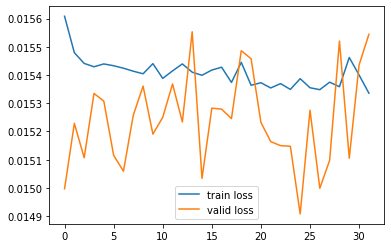

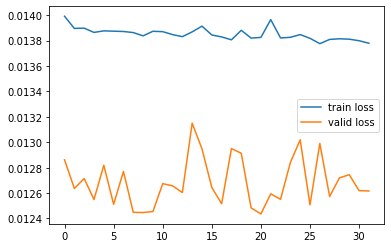

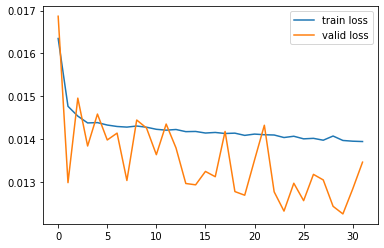

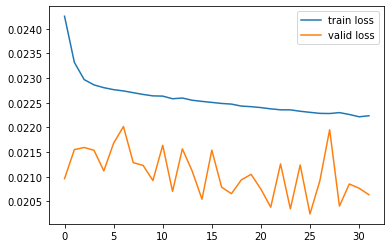

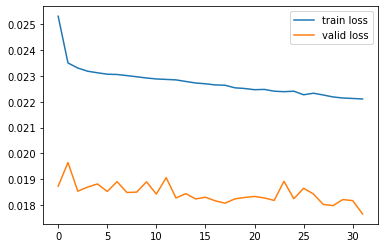

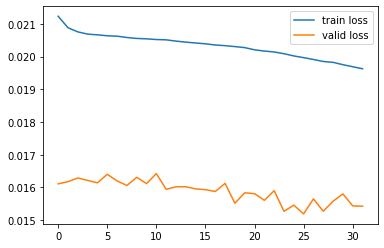

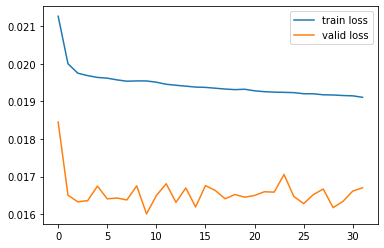

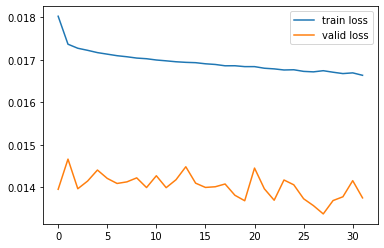

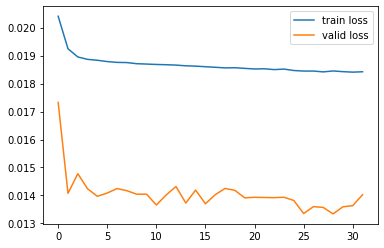

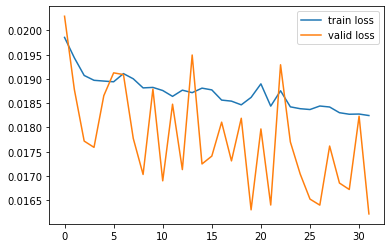

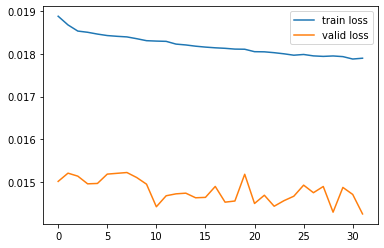

In [30]:
for history in historylist:
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="valid loss")
    plt.legend()
    plt.show()

In [31]:
origindatalist[0]

,PM10(t),SO2(t),NO2(t),CO(t),O3(t),RAIN(t),WSPM(t),RH(t),PM2.5
0,0.002037,0.010902,0.017361,0.020202,0.181619,0.0,0.392857,0.198898,0.001117
1,0.006110,0.010902,0.017361,0.020202,0.181619,0.0,0.419643,0.219976,0.005587
2,0.005092,0.013837,0.027778,0.020202,0.172158,0.0,0.500000,0.219976,0.004469
3,0.004073,0.031447,0.031250,0.020202,0.169792,0.0,0.276786,0.198840,0.003352
4,0.001018,0.034382,0.034722,0.020202,0.169792,0.0,0.178571,0.207946,0.000000
...,...,...,...,...,...,...,...,...,...
35059,0.027495,0.013837,0.114583,0.030303,0.224193,0.0,0.214286,0.073184,0.010056
35060,0.035642,0.019707,0.149306,0.040404,0.191080,0.0,0.080357,0.093626,0.011173
35061,0.035642,0.028512,0.222222,0.060606,0.136679,0.0,0.098214,0.126122,0.014525
35062,0.042770,0.034382,0.295139,0.060606,0.082278,0.0,0.107143,0.135748,0.020112


In [32]:
# test loss
predictionlist=[]
expectationlist=[]

for model,station,te_x,te_y,df,split_point,max_value,min_value in zip(modellist,station_info,test_x,test_y,origindatalist,split_pointlist,maxlist,minlist):
    print(model.evaluate(te_x, te_y, verbose=0),station)
    prediction = model.predict(te_x)
    
    prediction = prediction[:, 0] * (max_value - min_value) + min_value
    predictionlist.append(prediction)
    print(len(te_x),split_point[1],len(df))
    expectation = (df["PM2.5"][split_point[1] + look_back: ]* (max_value - min_value) + min_value).values
    expectationlist.append(expectation)

0.014580423594306374 Aotizhongxin
6376 25500 31876
0.014649467835519648 Changping
6555 26219 32774
0.01031935293980797 Dingling
6280 25119 31399
0.01937080426284052 Dongsi
6081 24321 30402
0.021933310211771806 Guanyuan
6466 25862 32328
0.015331727343283103 Huairou
6391 25564 31955
0.017054695946755558 Nongzhanguan
6636 26540 33176
0.013459105638439465 Shunyi
6118 24469 30587
0.01613034599168332 Tiantan
6582 26325 32907
0.015994940958941377 Wanliu
6148 24589 30737
0.015485005011113133 Wanshouxigong
6566 26263 32829


In [33]:
expectationlist[0][0],predictionlist[0][0]

(10.0, 10.9470825)

In [34]:
origindatalist[0]

,PM10(t),SO2(t),NO2(t),CO(t),O3(t),RAIN(t),WSPM(t),RH(t),PM2.5
0,0.002037,0.010902,0.017361,0.020202,0.181619,0.0,0.392857,0.198898,0.001117
1,0.006110,0.010902,0.017361,0.020202,0.181619,0.0,0.419643,0.219976,0.005587
2,0.005092,0.013837,0.027778,0.020202,0.172158,0.0,0.500000,0.219976,0.004469
3,0.004073,0.031447,0.031250,0.020202,0.169792,0.0,0.276786,0.198840,0.003352
4,0.001018,0.034382,0.034722,0.020202,0.169792,0.0,0.178571,0.207946,0.000000
...,...,...,...,...,...,...,...,...,...
35059,0.027495,0.013837,0.114583,0.030303,0.224193,0.0,0.214286,0.073184,0.010056
35060,0.035642,0.019707,0.149306,0.040404,0.191080,0.0,0.080357,0.093626,0.011173
35061,0.035642,0.028512,0.222222,0.060606,0.136679,0.0,0.098214,0.126122,0.014525
35062,0.042770,0.034382,0.295139,0.060606,0.082278,0.0,0.107143,0.135748,0.020112


In [35]:
# print("prediction's shape = {}, expectation's shape = {}".format(predictionlist[1].shape, expectationlist[1].shape))

[0.9293752]


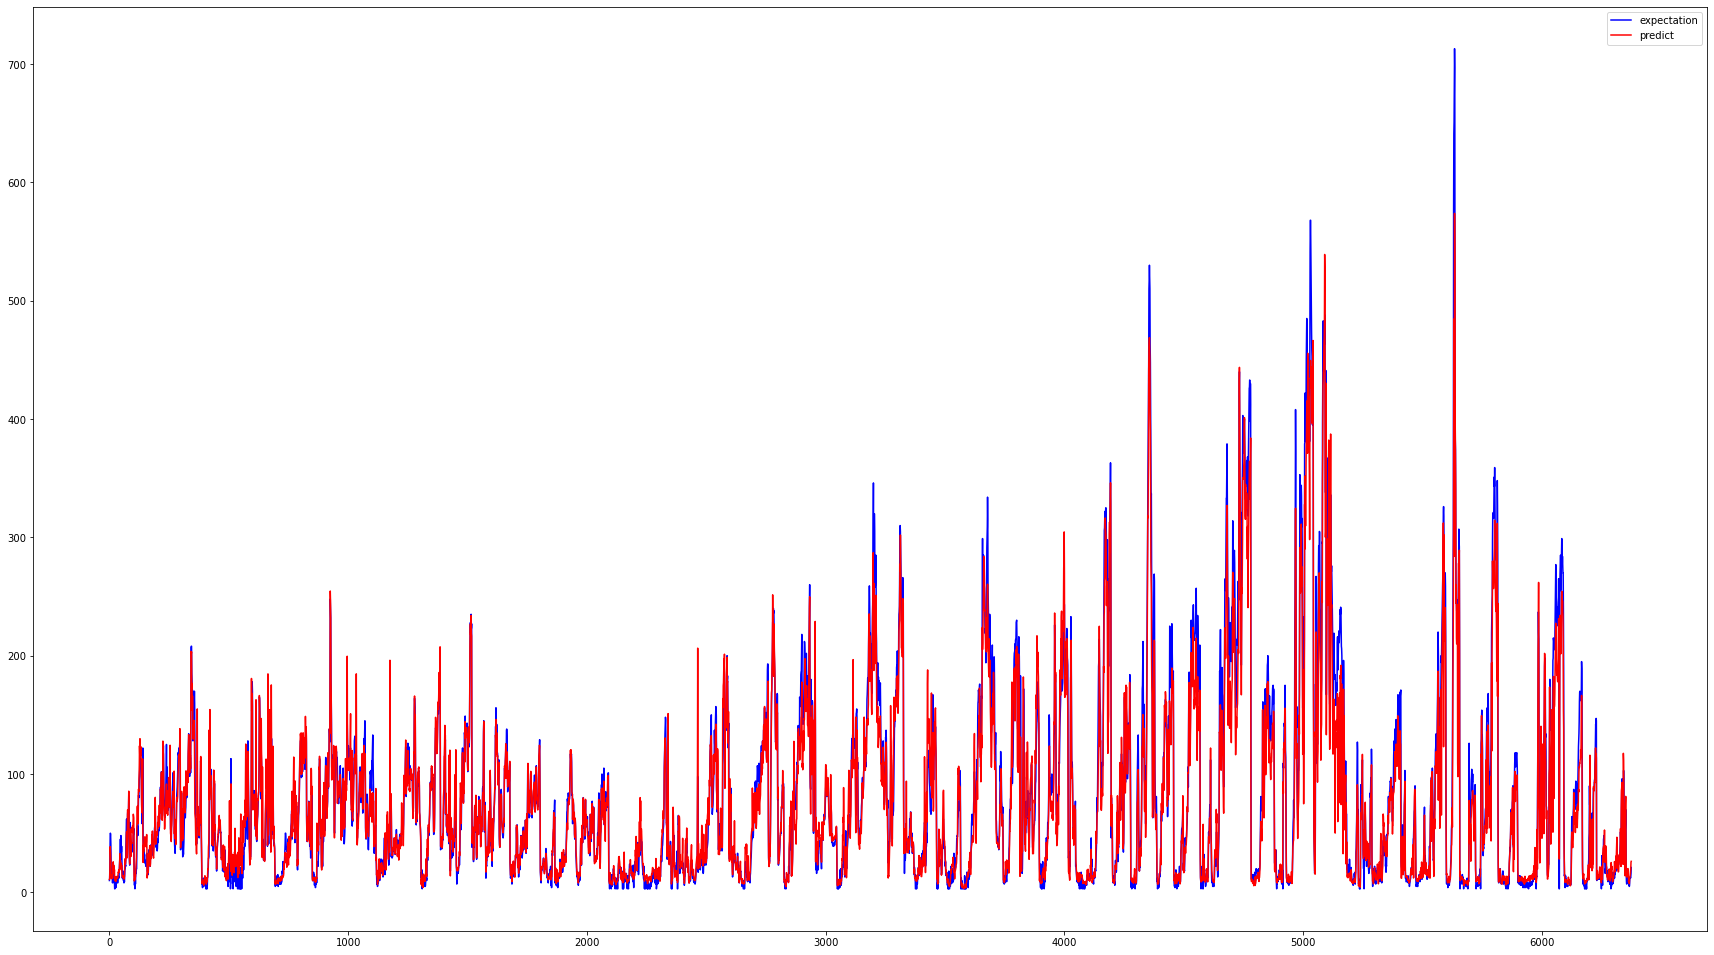

[0.92055401]


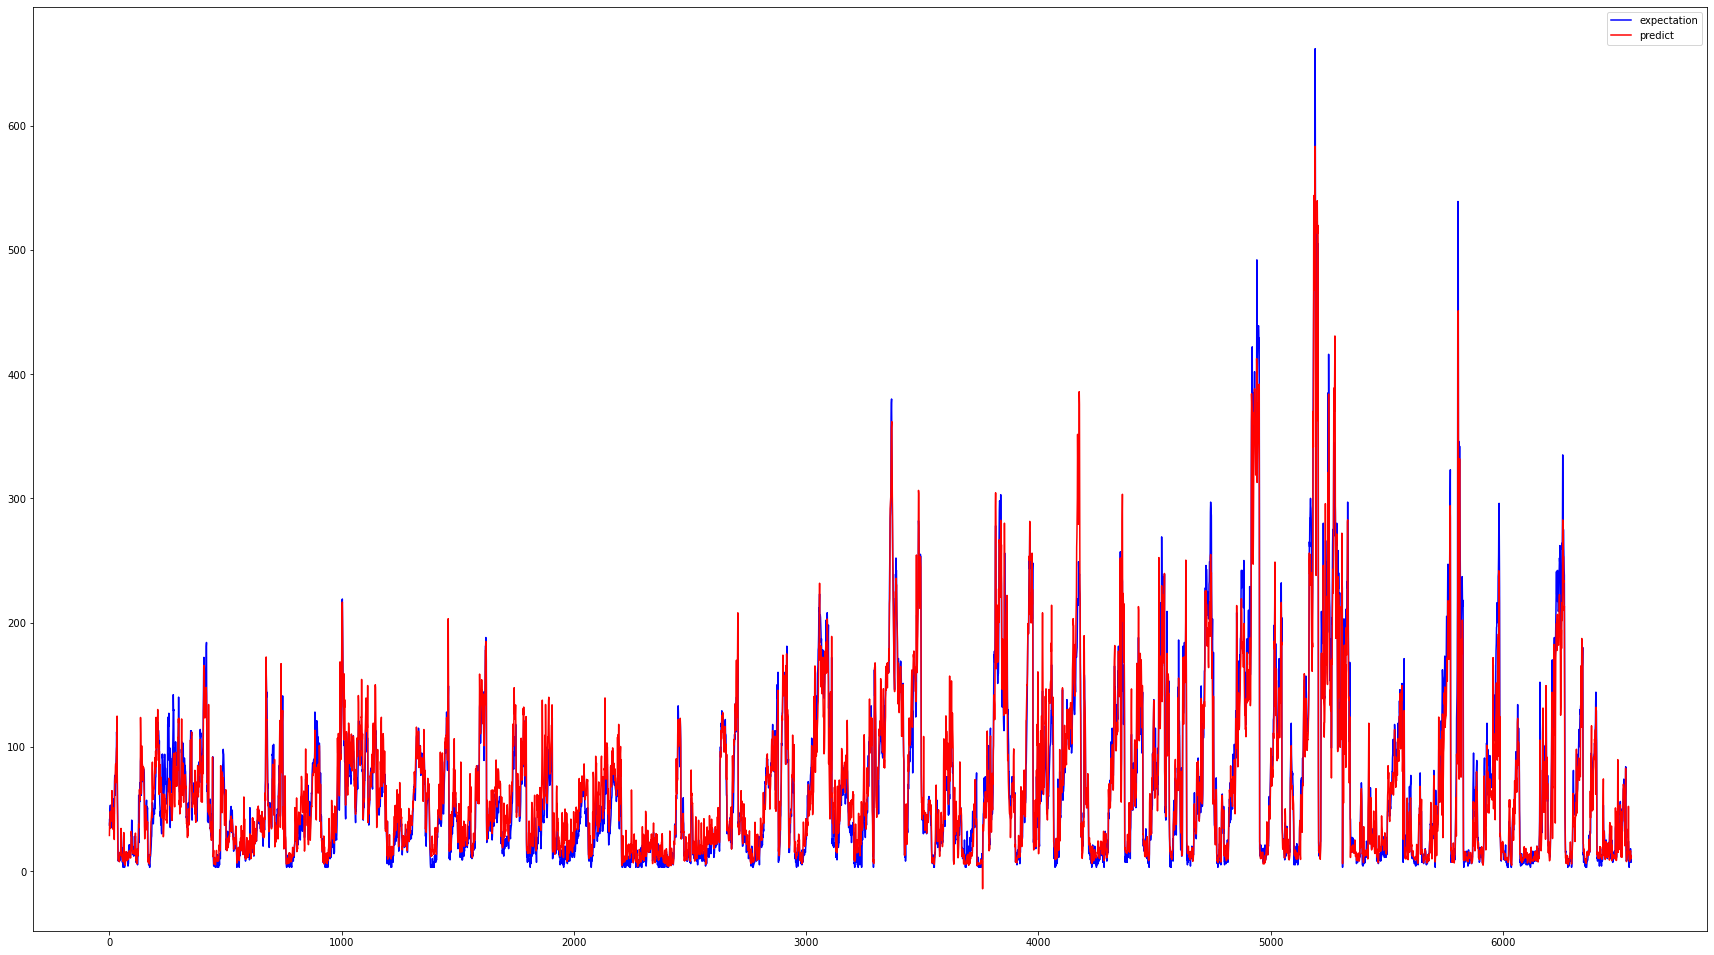

[0.95239604]


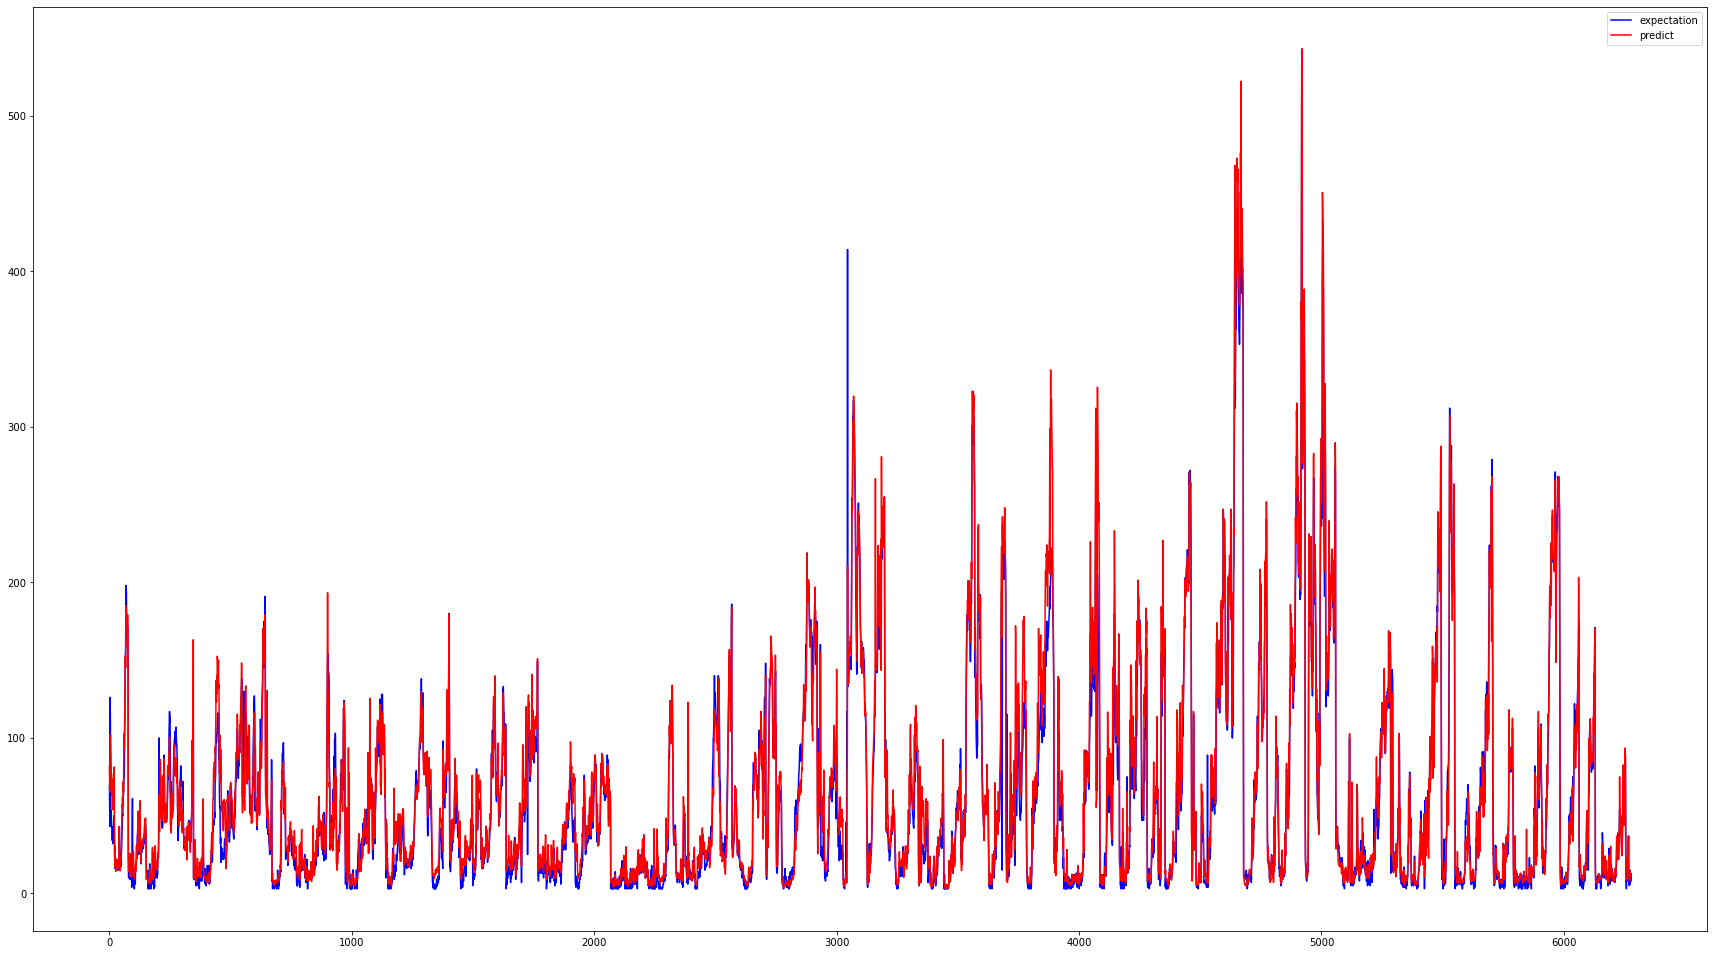

[0.93457991]


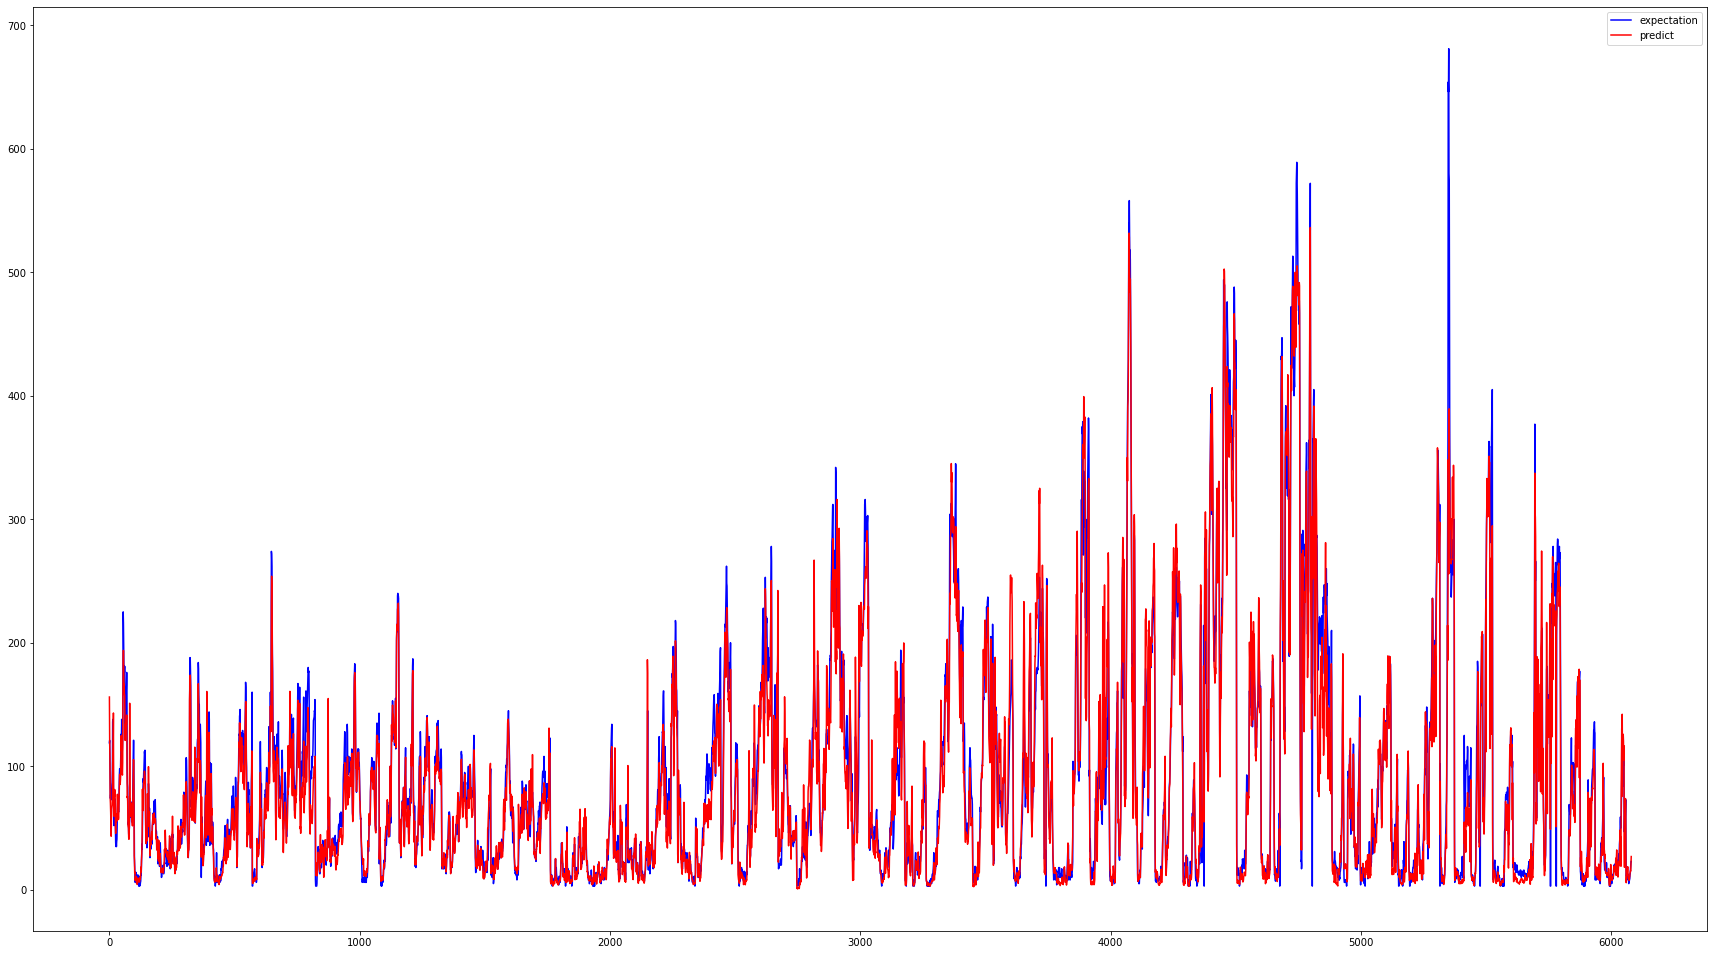

[0.92940689]


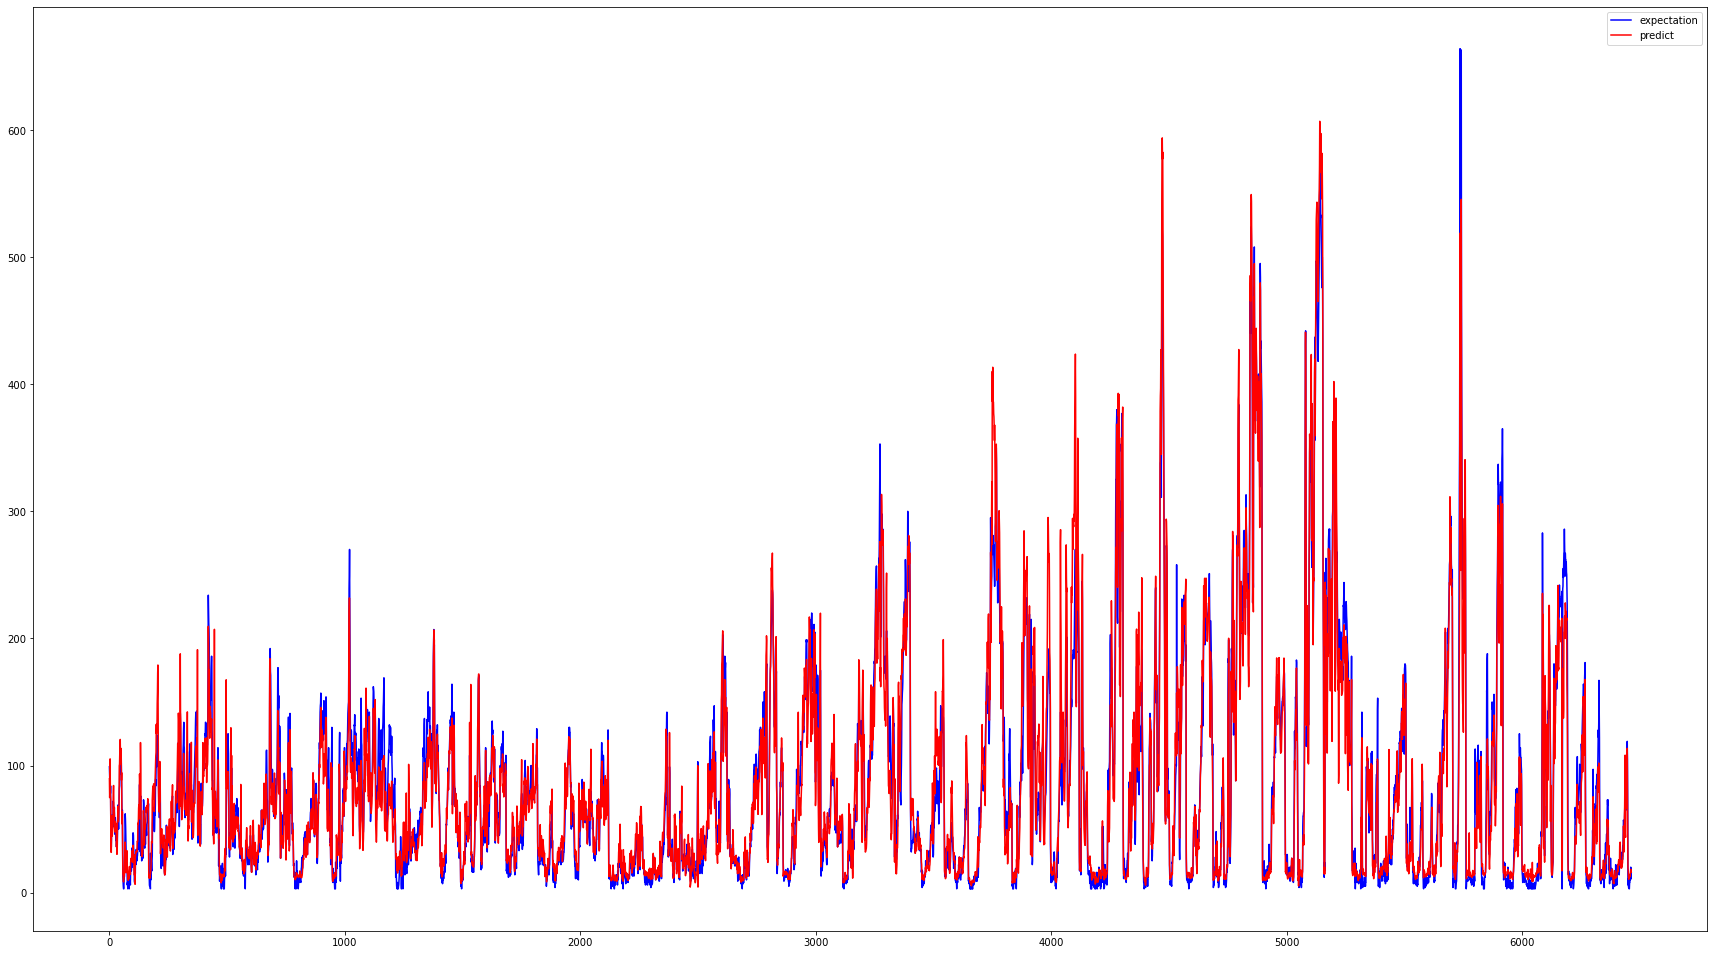

[0.91281583]


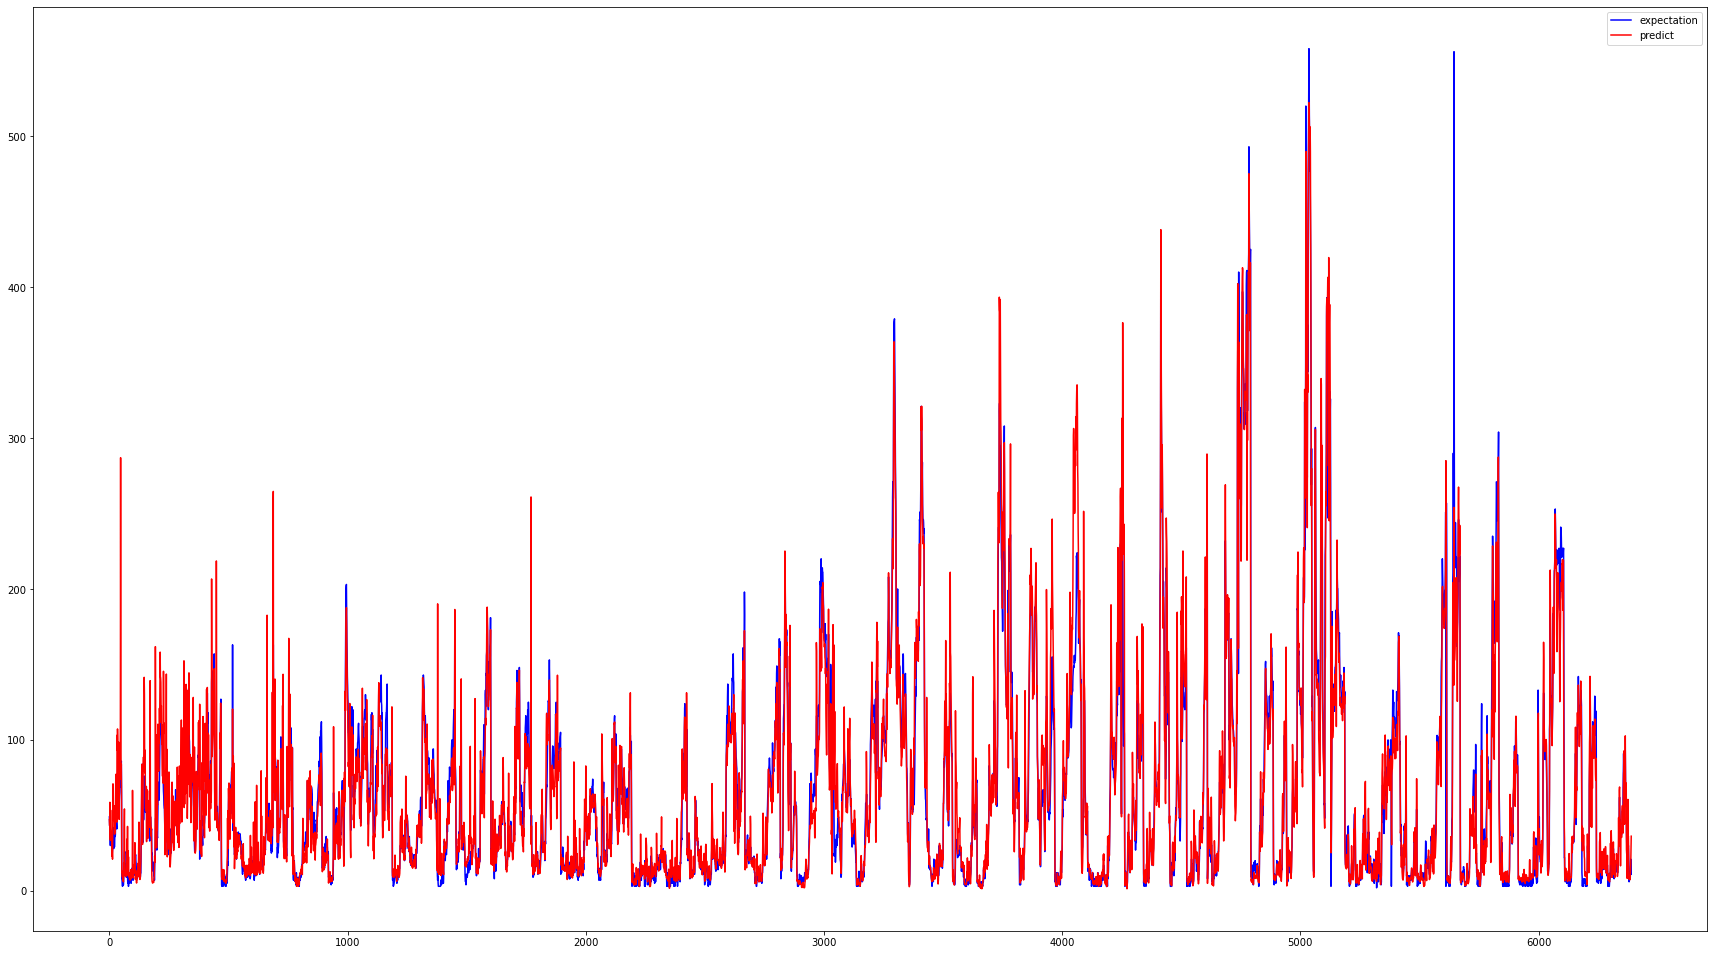

[0.92956917]


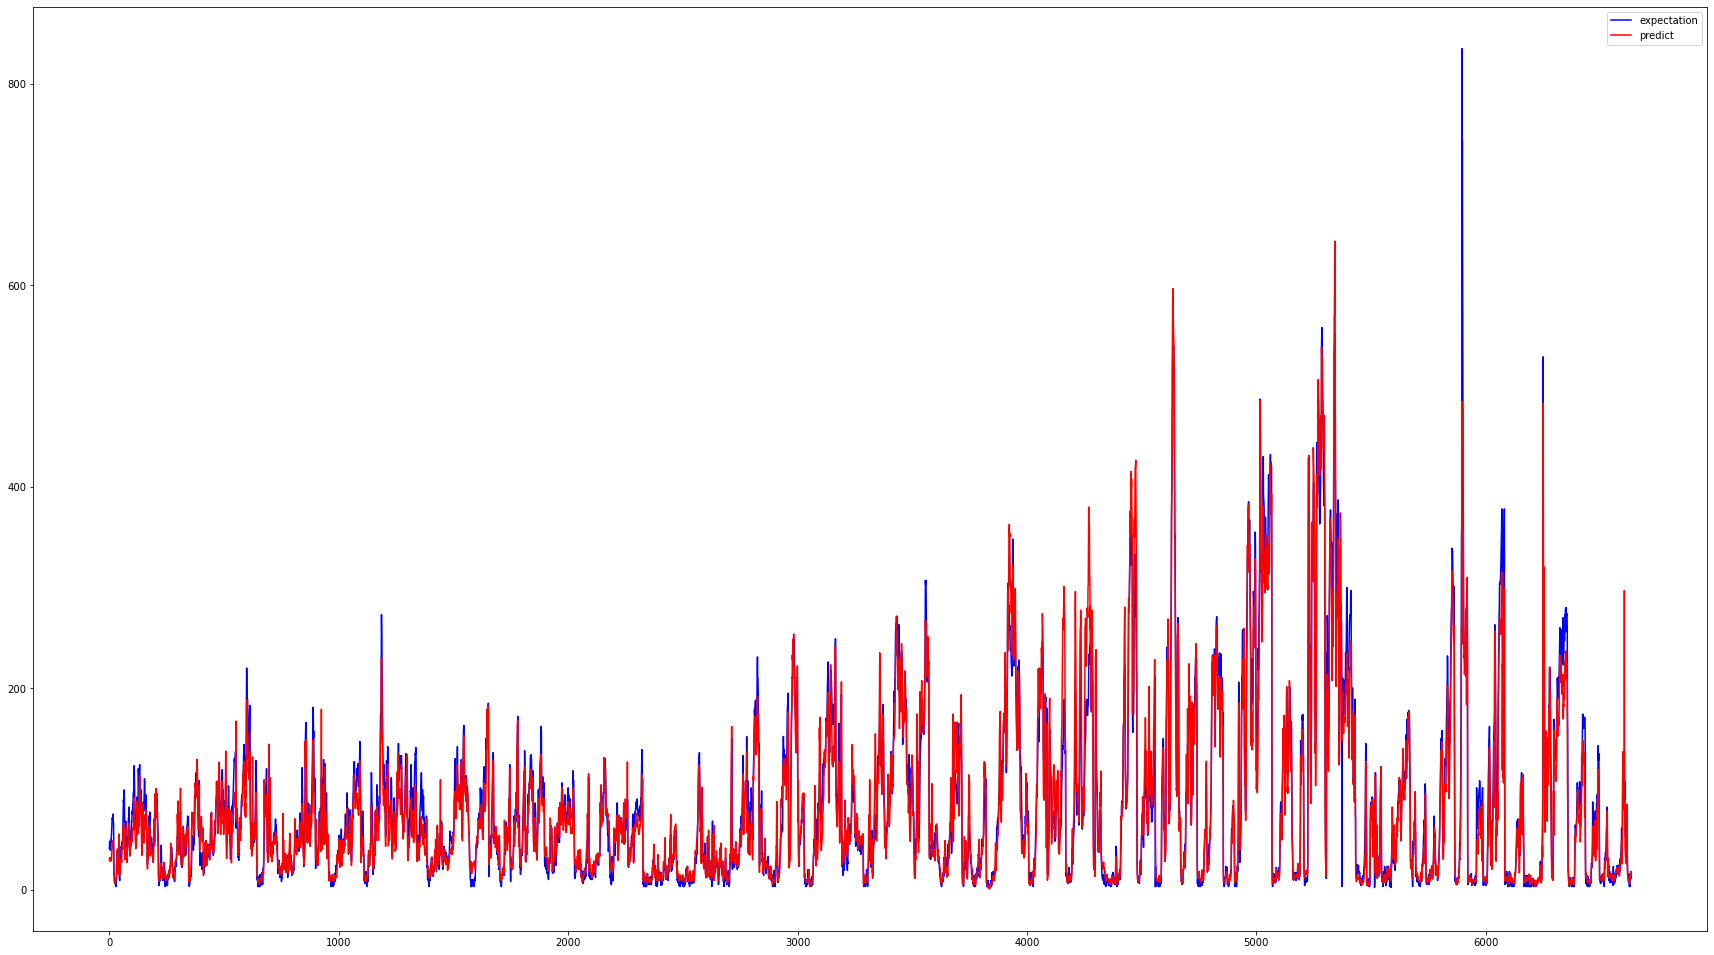

[0.93258367]


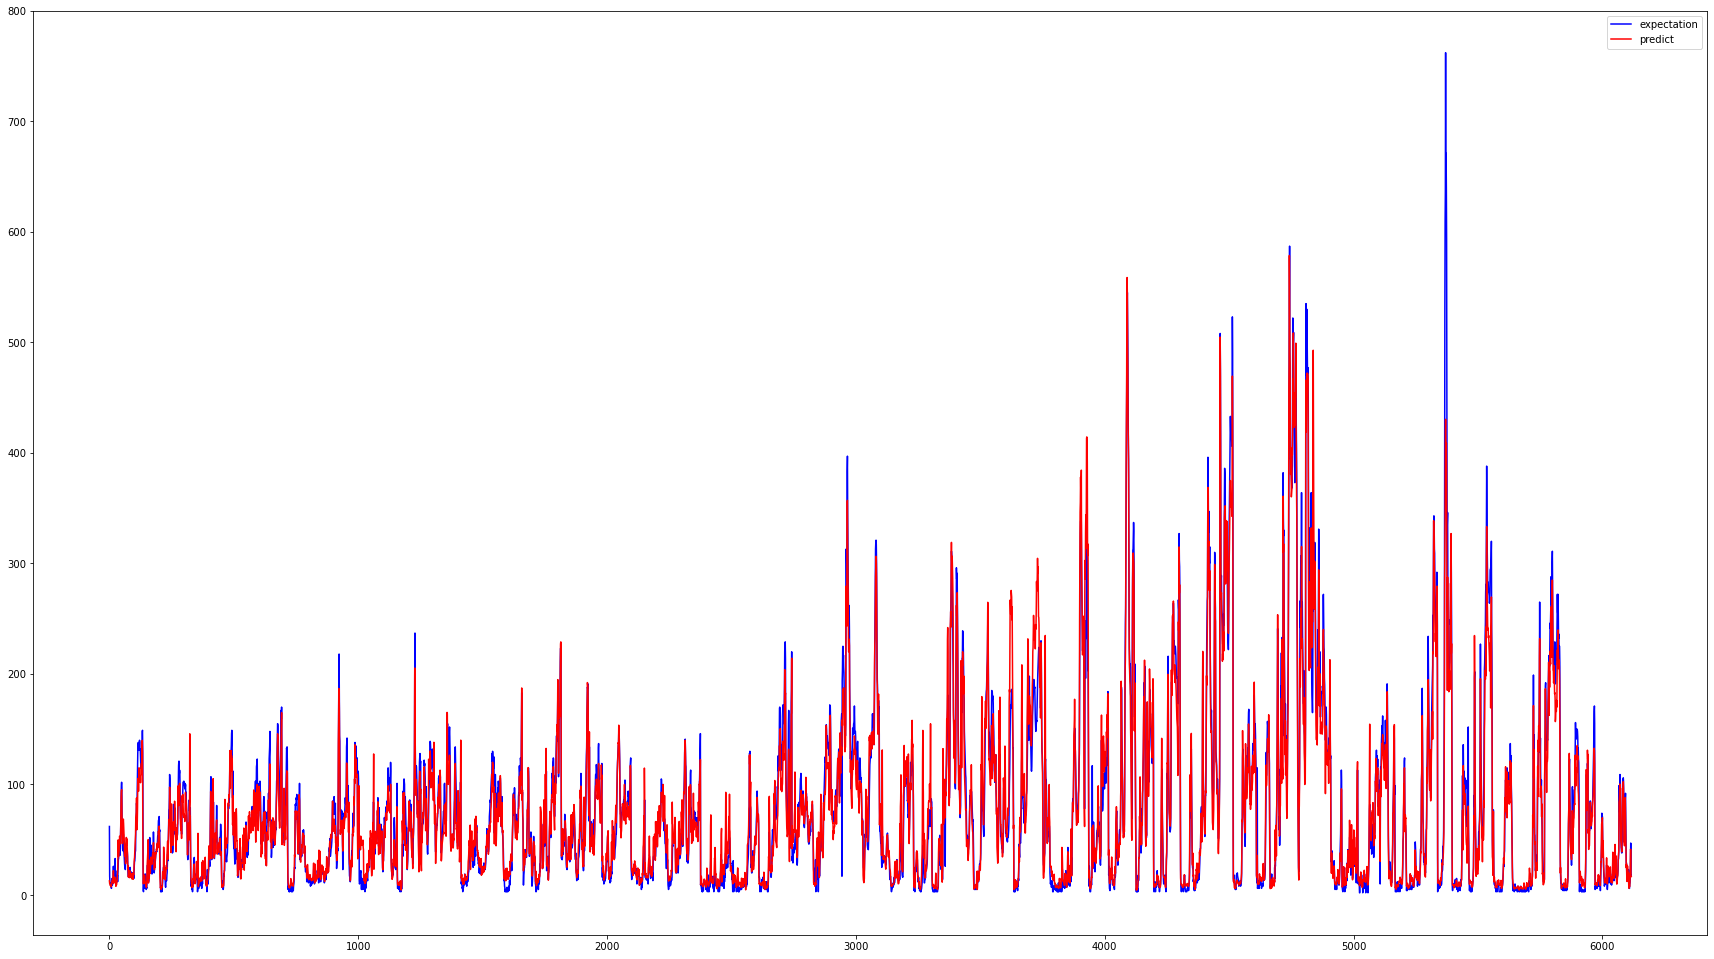

[0.93540879]


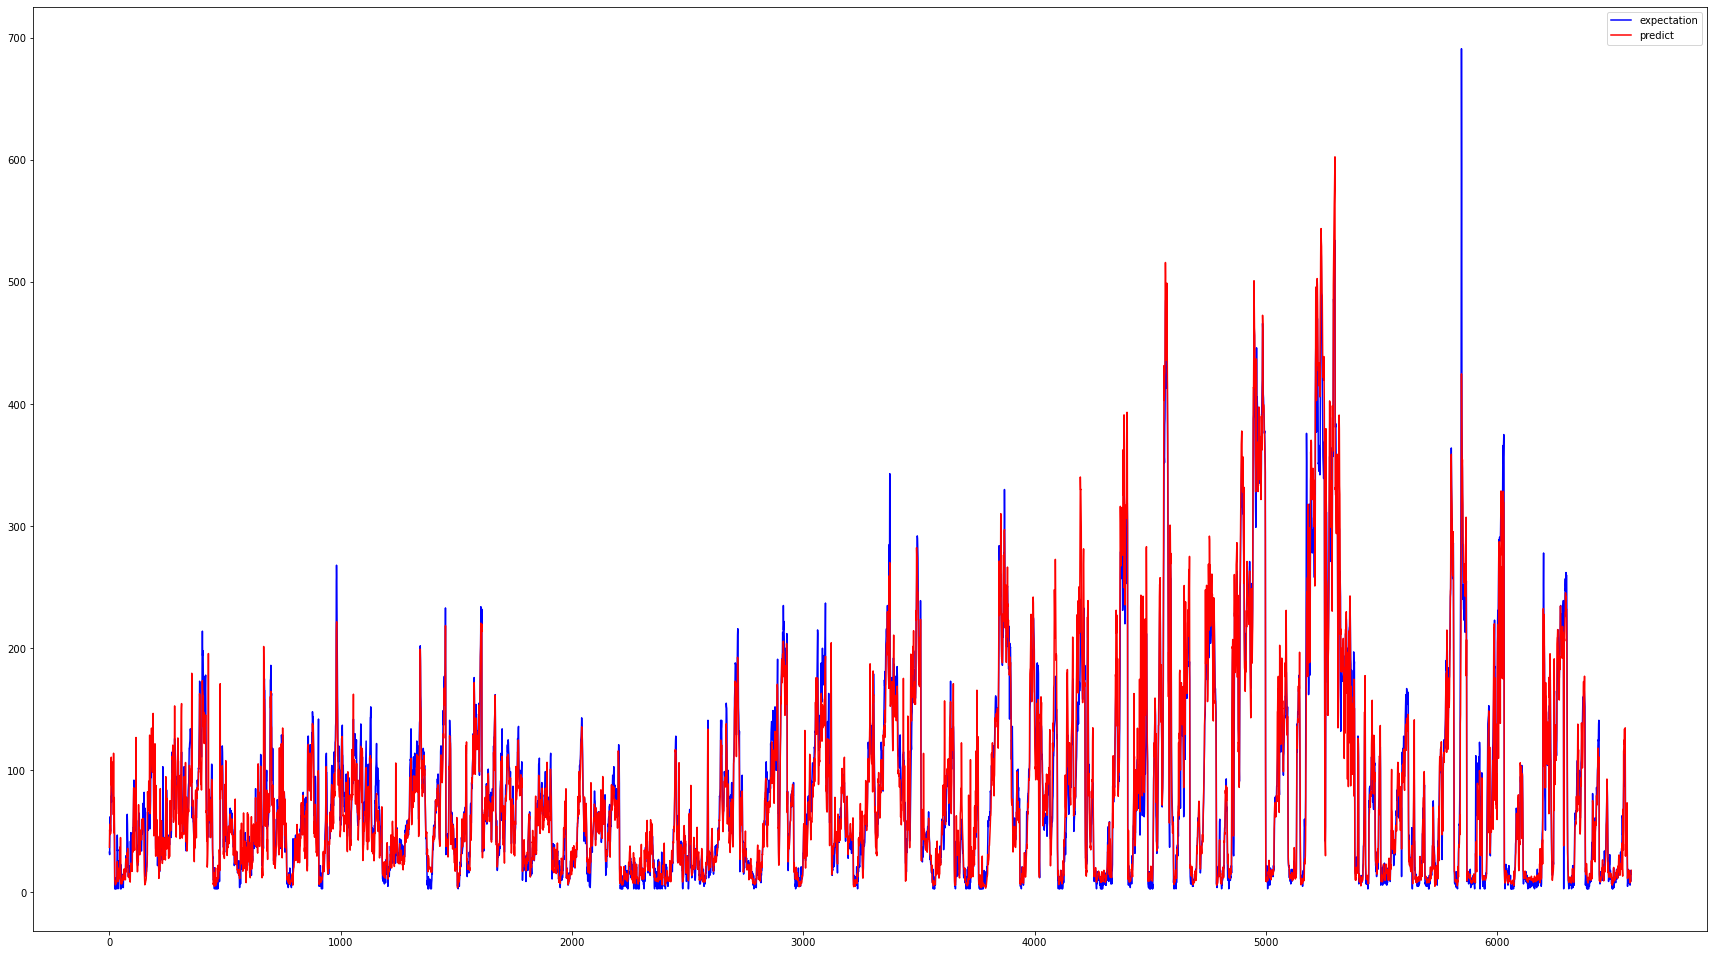

[0.92367452]


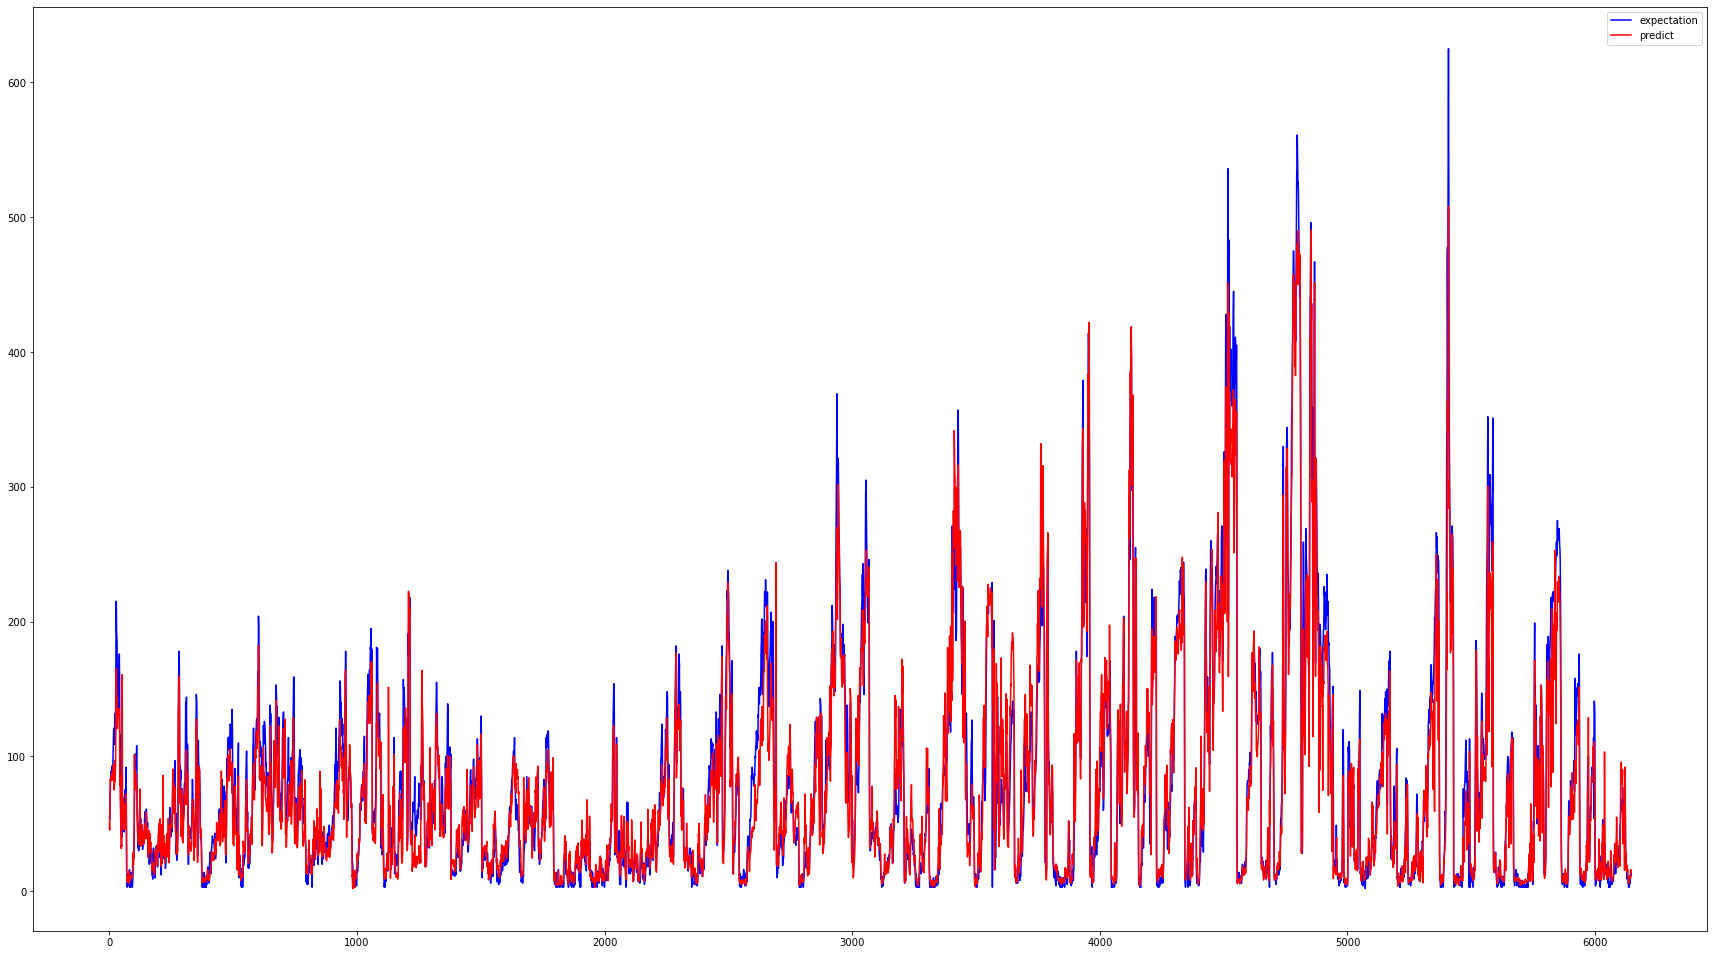

[0.91556191]


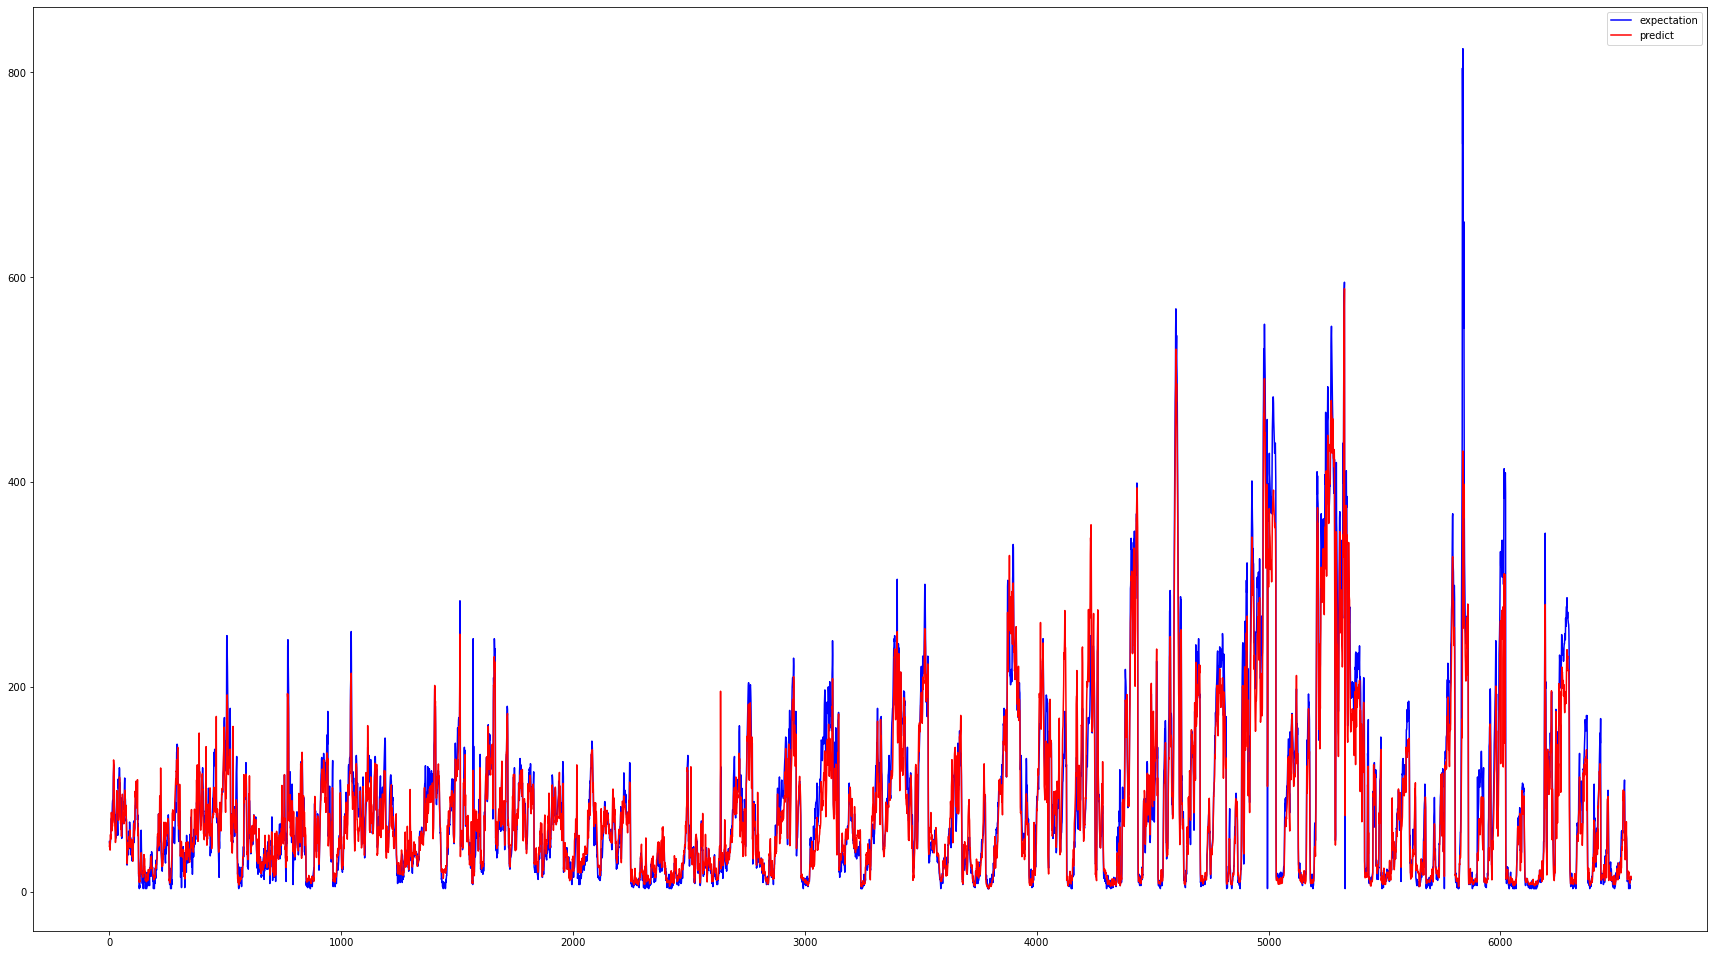

In [36]:
# calculate R-square
for expectation,prediction in zip (expectationlist,predictionlist):
    print(r2_score(expectation, prediction, multioutput="raw_values"))
    plt.figure(figsize=(30, 17))
    start=0
    end=-1
    plt.plot(expectation[start:end], label="expectation",color="blue")
    plt.plot(prediction[start:end], label="predict", color="red")
    plt.legend()
    plt.show()

In [37]:
# Now save the model
for model,station in zip(modellist,station_info):
    model.save("./model/"+station+"/")

INFO:tensorflow:Assets written to: ./model/Aotizhongxin/assets
INFO:tensorflow:Assets written to: ./model/Changping/assets
INFO:tensorflow:Assets written to: ./model/Dingling/assets
INFO:tensorflow:Assets written to: ./model/Dongsi/assets
INFO:tensorflow:Assets written to: ./model/Guanyuan/assets
INFO:tensorflow:Assets written to: ./model/Huairou/assets
INFO:tensorflow:Assets written to: ./model/Nongzhanguan/assets
INFO:tensorflow:Assets written to: ./model/Shunyi/assets
INFO:tensorflow:Assets written to: ./model/Tiantan/assets
INFO:tensorflow:Assets written to: ./model/Wanliu/assets
INFO:tensorflow:Assets written to: ./model/Wanshouxigong/assets


## test load model

In [38]:
testorder=1

In [39]:
minmaxlist=pd.read_csv("./model/min_max_x.csv")
minmaxlist

,PM2.5min,PM2.5max,PM10min,PM10max,SO2min,SO2max,NO2min,NO2max,COmin,COmax,...,O3max,PRESmin,PRESmax,RAINmin,RAINmax,WSPMmin,WSPMmax,RHmin,RHmax,Unnamed: 20
0,3.0,898.0,2.0,984.0,0.2856,341.0,2.0000,290.0,100.0,10000.0,...,423.0000,985.9,1042.0,0.0,72.5,0.0,11.2,0.049785,1.0,NaN
1,2.0,882.0,2.0,999.0,0.2856,310.0,1.8477,226.0,100.0,10000.0,...,429.0000,982.4,1036.5,0.0,52.1,0.0,10.0,0.029618,1.0,NaN
2,3.0,881.0,2.0,905.0,0.2856,156.0,1.0265,205.0,100.0,10000.0,...,500.0000,982.4,1036.5,0.0,52.1,0.0,10.0,0.029618,1.0,NaN
3,3.0,737.0,2.0,955.0,0.2856,300.0,2.0000,258.0,100.0,10000.0,...,1071.0000,987.1,1042.0,0.0,46.4,0.0,10.5,0.049337,1.0,NaN
4,2.0,680.0,2.0,999.0,1.0000,293.0,2.0000,270.0,100.0,10000.0,...,415.0000,985.9,1042.0,0.0,72.5,0.0,11.2,0.049785,1.0,NaN
5,2.0,762.0,2.0,993.0,0.2856,315.0,1.0265,231.0,100.0,10000.0,...,444.0000,982.8,1036.5,0.0,45.9,0.0,12.9,0.016438,1.0,NaN
6,2.0,844.0,2.0,995.0,0.5712,257.0,2.0000,273.0,100.0,10000.0,...,390.0000,987.1,1042.0,0.0,46.4,0.0,10.5,0.049337,1.0,NaN
7,2.0,941.0,2.0,999.0,0.2856,239.0,2.0000,258.0,100.0,10000.0,...,351.7164,988.0,1042.8,0.0,37.3,0.0,12.8,0.049325,1.0,NaN
8,3.0,821.0,2.0,988.0,0.5712,273.0,2.0000,241.0,100.0,10000.0,...,674.0000,987.1,1042.0,0.0,46.4,0.0,10.5,0.049337,1.0,NaN
9,2.0,957.0,2.0,951.0,0.2856,282.0,1.6424,264.0,100.0,10000.0,...,364.0000,985.9,1040.3,0.0,72.5,0.0,11.2,0.049259,1.0,NaN


In [40]:
new_model = tf.keras.models.load_model('./model/'+station_info[testorder])

In [41]:
prediction = new_model.predict(test_x[testorder])[:, 0] *(minmaxlist["PM2.5max"][testorder] - minmaxlist["PM2.5min"][testorder]) + minmaxlist["PM2.5min"][testorder]
expectation=(origindatalist[testorder]["PM2.5"][split_pointlist[testorder][1] + look_back: ]*(minmaxlist["PM2.5max"][testorder] - minmaxlist["PM2.5min"][testorder]) + minmaxlist["PM2.5min"][testorder]).values

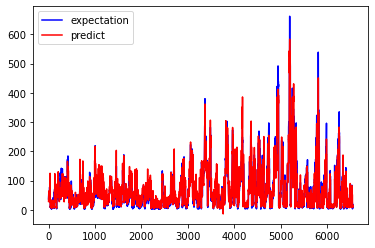

In [42]:
plt.plot(expectation[start:end], label="expectation",color="blue")
plt.plot(prediction[start:end], label="predict", color="red")
plt.legend()
plt.show()